# 의사결정나무(Decision Tree)실습

## 라이브러리 불러오기

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source
from IPython.display import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")

## 데이터 불러오기

In [5]:
data = pd.read_csv("BreastCancerWisconsin.csv")
print("- Data has {} rows and {} columns.".format(*data.shape))
print("- Column names: ", list(data.columns))

X = data.drop(['diagnosis'], axis=1)
X = X.iloc[:, :10]
y = data['diagnosis']

- Data has 569 rows and 31 columns.
- Column names:  ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'diagnosis']


### [TIP1] 분석에 앞서 Class distribution 확인 
### Class 불균형 발생시, 일반적인 모델링으로는 우수한 성능을 내기 어려움 

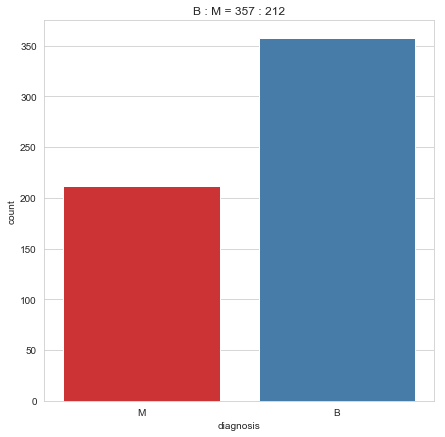

In [6]:
# Check class label distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sns.countplot(y, palette='Set1', ax=ax)
ax.set_title("B : M = {} : {}".format(*y.value_counts()))
plt.show()

### [TIP2] 변수간 Correlation 확인

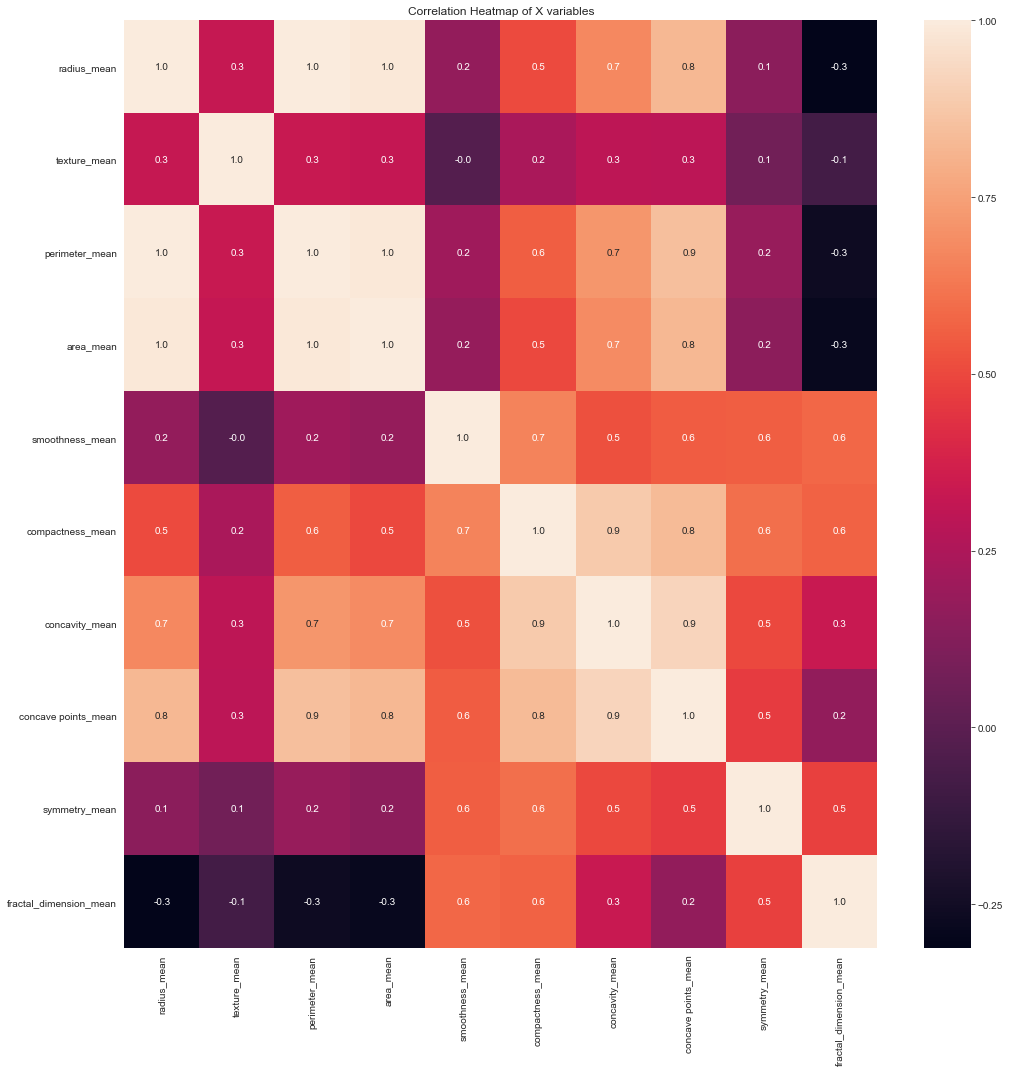

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax = sns.heatmap(X.corr(), annot=True, fmt='.1f')
ax.set_title("Correlation Heatmap of X variables")
plt.tight_layout()
plt.show(fig)

### 학습을 위해 Train / Test 데이터 분리

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=1/10,
                                                    stratify=y,
                                                    random_state=2015010720)

### Train 데이터에 대해 
### 1. scaling을 통한 변수 범위 일치
### 2. validation set 분리 - parameter 튜닝 목적

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=1/9,
                                                      stratify=y_train,
                                                      random_state=2015010720)

## Decision Tree 모델 구축
### 풀고자 하는 문제의 종류에 따라 다른 criterion 사용이 필요함
#### 분류문제 : gini index 사용
#### 회귀문제 : mse

In [13]:
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 예측 수행(train / valid)

In [15]:
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)

# Show train & validation accuracies
print('- Accuracy (Train)      : {:.4}'.format(accuracy_score(y_train, y_train_pred)))
print('- Accuracy (Validation) : {:.4}'.format(accuracy_score(y_valid, y_valid_pred)))
# Show train & validation f1 scores
print('- F1 score (Train)      : {:.4}'.format(f1_score(y_train, y_train_pred, pos_label='M')))
print('- F1 score (Validation) : {:.4}'.format(f1_score(y_valid, y_valid_pred, pos_label='M')))

- Accuracy (Train)      : 1.0
- Accuracy (Validation) : 0.9298
- F1 score (Train)      : 1.0
- F1 score (Validation) : 0.9048


## Decision Tree의 장점은 데이터 분할 기준에 따른 규칙 생성이 가능
### 규칙의 시각화

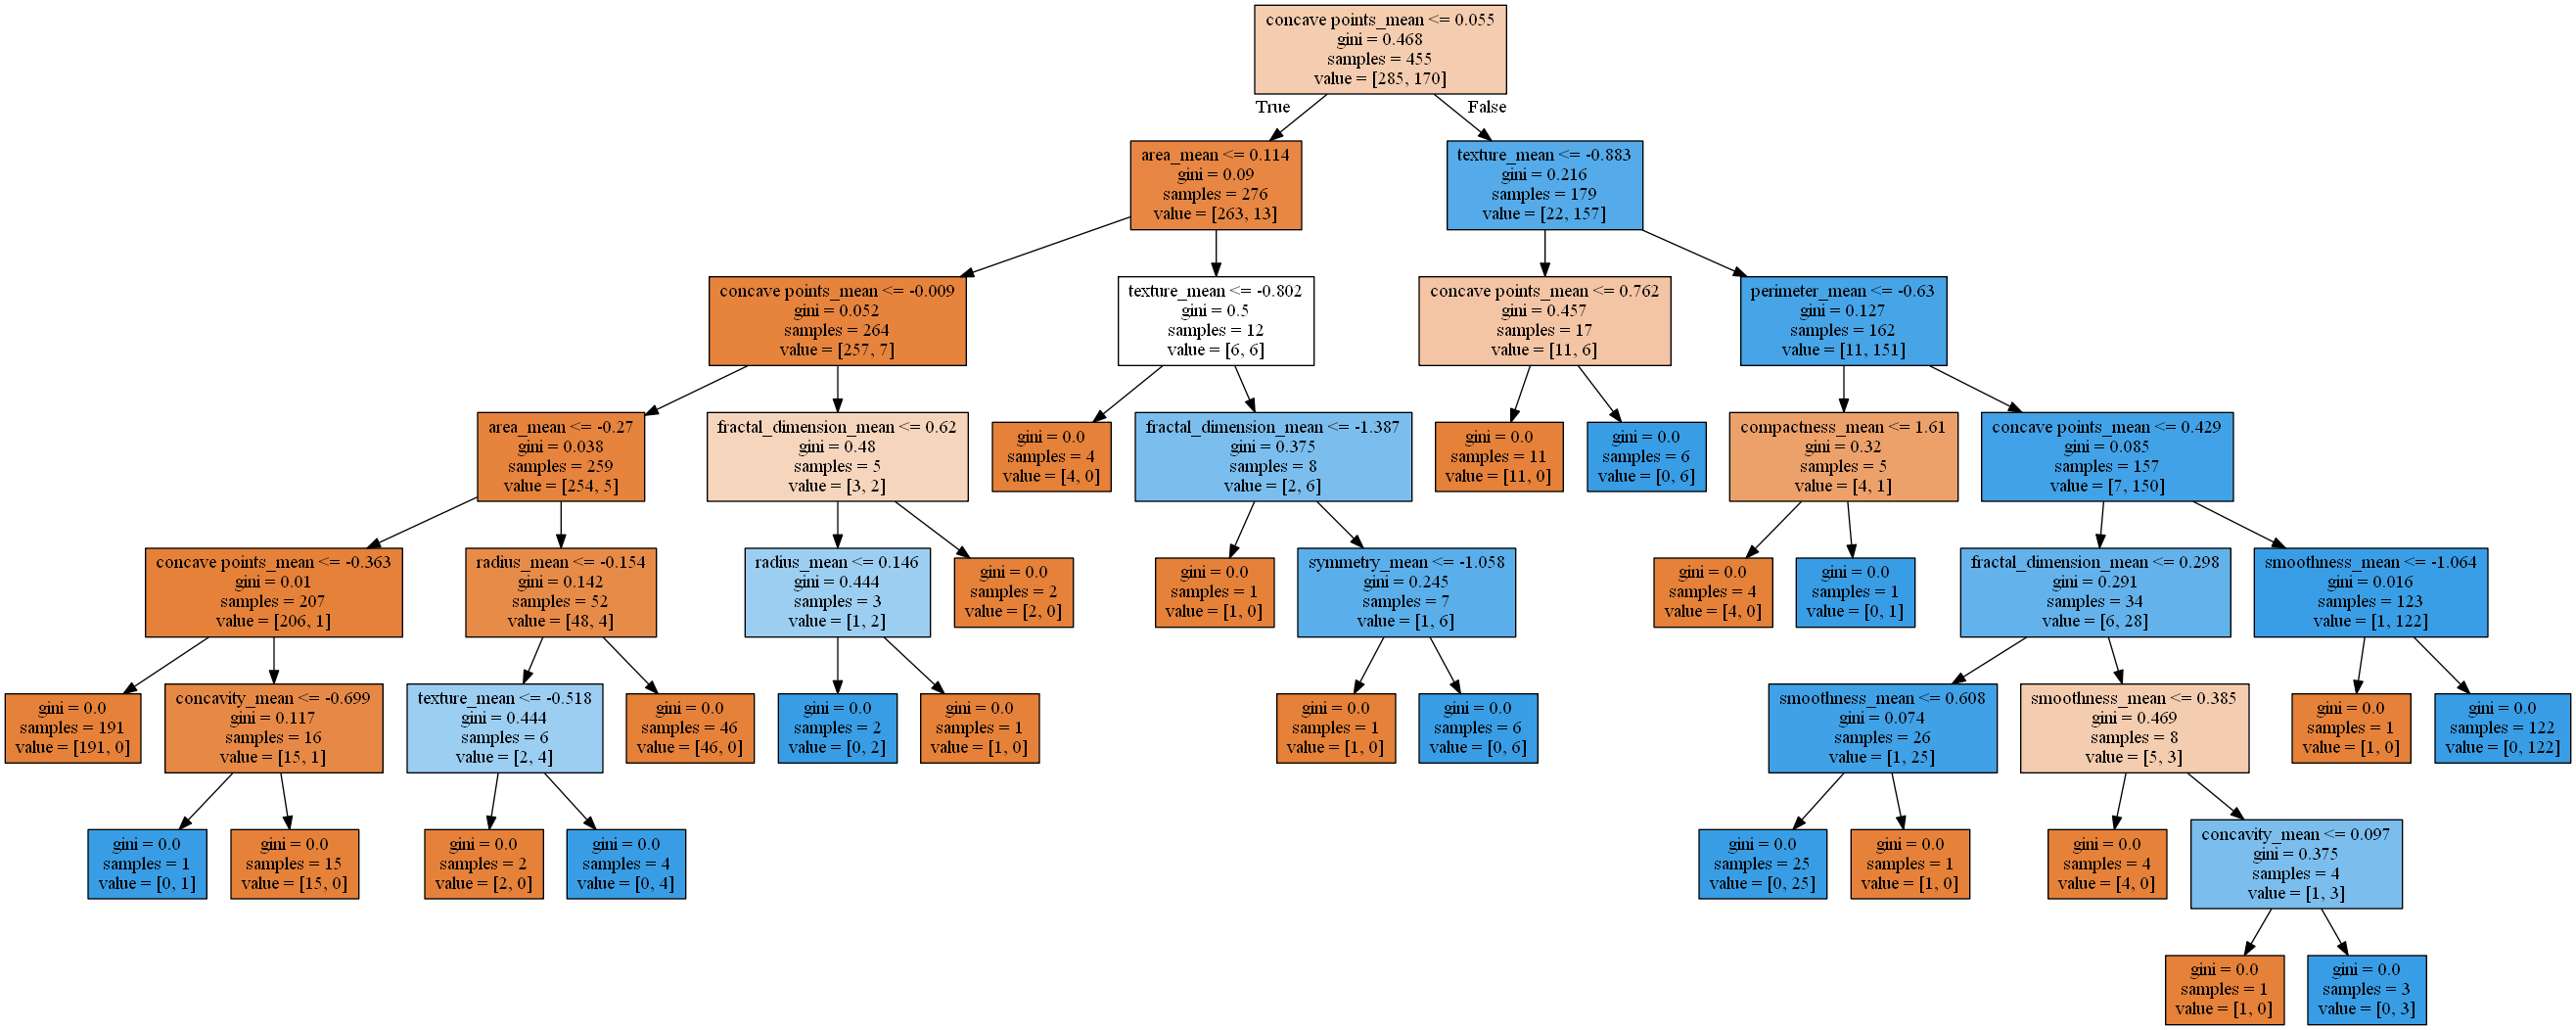

In [16]:
graph = Source(export_graphviz(clf_dt,
                               out_file=None,
                               feature_names=X.columns,
                               filled=True,
                               leaves_parallel=False))
Image(graph.pipe(format='png'))

### 데이터에 적합한 모델을 구축하기 위해 parameter 튜닝이 필요함 
#### DT에는 모델의 depth를 적정하게 설정하는 것이 중요함 (overfitting 가능성 최소화)

In [17]:
max_depths = list(range(1, 9, 1))
validation_accs = []
validation_f1 = []
dt_models = []
for max_depth in max_depths:
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    clf_dt.fit(X_train, y_train)
    dt_models.append(clf_dt)
    y_valid_pred = clf_dt.predict(X_valid)
    validation_accs.append(accuracy_score(y_valid, y_valid_pred))
    validation_f1.append(f1_score(y_valid, y_valid_pred, pos_label='M'))

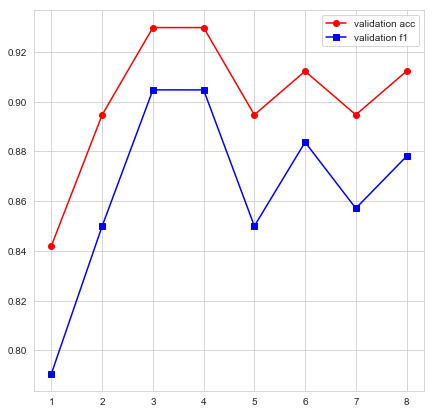

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(max_depths, validation_accs, color='red', marker='o', label='validation acc')
ax.plot(max_depths, validation_f1, color='blue', marker='s', label='validation f1')
ax.legend(loc='best')
plt.show(fig)

### Validation set에 대해 우수한 성능을 보였던 depth는 3 또는 4
#### 우리는 depth를 3,4로 설정할때 test set에 대해서도 상대적으로 우수한 성능을 보일것이라 기대할 수 있음

In [19]:
best_model_idx, best_model_f1 = max(enumerate(validation_f1), key=lambda p: p[1])
y_test_pred = dt_models[best_model_idx].predict(X_test)
print('- Accuracy (Test) : {:.4}'.format(accuracy_score(y_test, y_test_pred)))
print('- F1 score (Test) : {:.4}'.format(f1_score(y_test, y_test_pred, pos_label='M')))

- Accuracy (Test) : 0.9474
- F1 score (Test) : 0.9268


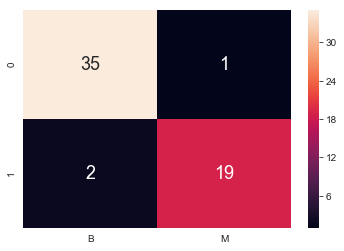

In [20]:
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test = pd.DataFrame(cm_test, columns=['B', 'M'])
sns.heatmap(data=cm_test, annot=True, annot_kws={'size': 18})

### Best Model에 대한 규칙 (시각화)

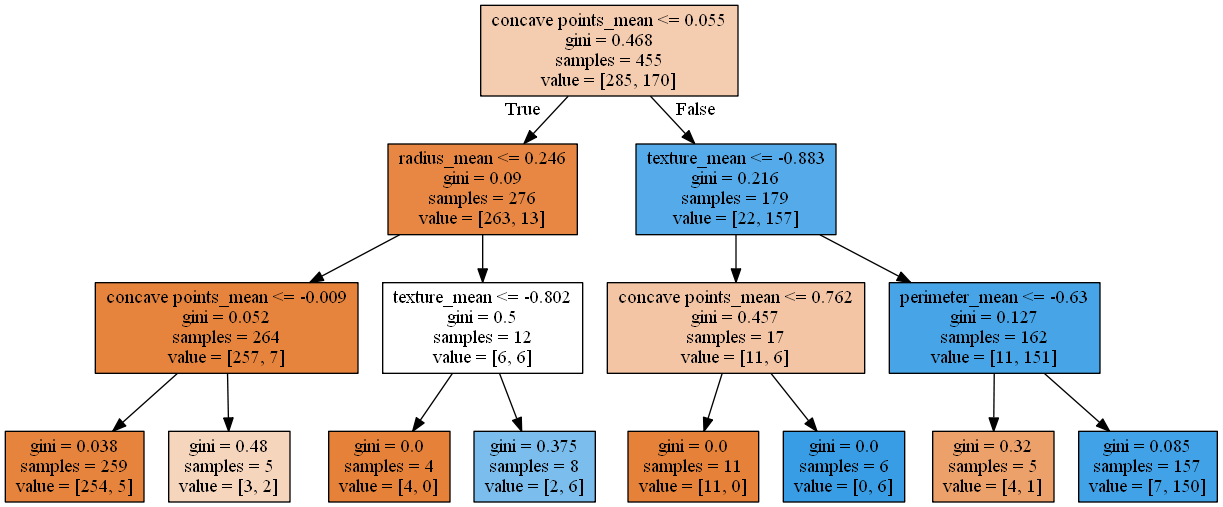

In [24]:
graph = Source(export_graphviz(dt_models[best_model_idx],
                               out_file=None,
                               feature_names=X.columns,
                               filled=True,
                               leaves_parallel=True))
png_bytes = graph.pipe(format='png')
Image(png_bytes)


In [25]:
with open('dt_best.png', 'wb') as f:
    f.write(png_bytes)

### DT는 규칙을 시각적으로 제공이 가능할 뿐만 아니라
### 각 변수의 중요도를 제공 (Linear regression의 coefficient와 유사한 개념)

In [26]:
imp = dt_models[best_model_idx].feature_importances_
imp = pd.DataFrame([X.columns, imp]).T
imp.columns = ['variables', 'importance']
print(imp[imp['importance'] != 0])

             variables importance
0          radius_mean  0.0281565
1         texture_mean  0.0728799
2       perimeter_mean  0.0302563
7  concave points_mean   0.868707


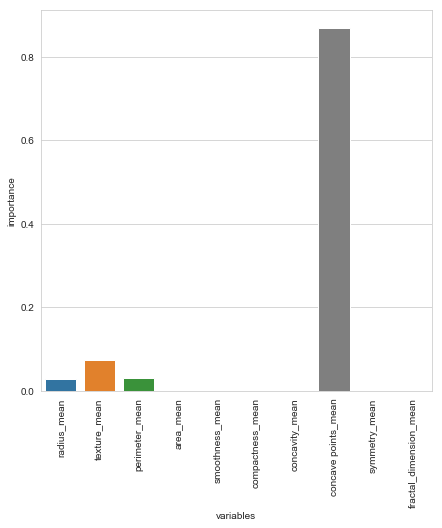

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='variables', y='importance', data=imp, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show(fig)

### 변수의 중요가 높다 = 분류(또는 회귀)를 수행하는데 critical한 역활을 한다
### 중요도 순위가 높은 2개의 변수를 사용하여 2차원 시각화를 수행

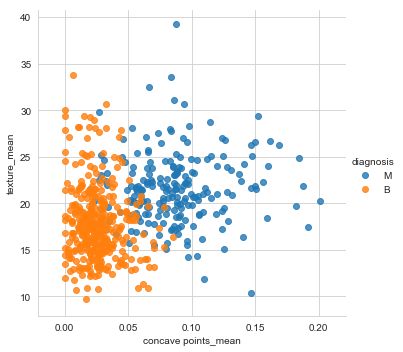

In [28]:
sns.lmplot(x='concave points_mean', y='texture_mean',
           hue='diagnosis', data=data, fit_reg=False)

### 2개의 변수 (concave_points_mean, texture_mean)을 사용하여도 2개의 class가 어느정도 분류가 됨을 확인 가능하다